# 2-b: Visualizing Neural Networks

#### To keep your modifications in case you want to come back later to this colab, do _File -> Save a copy in Drive_.


In [2]:
import io
import math
import os
import random

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from IPython.display import Image as nb_Image
from PIL import Image
from scipy.ndimage.filters import gaussian_filter1d
from torchvision import transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

/tmp/ipykernel_456829/2445262127.py:14: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


## Functions and useful variables


In [3]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(img, size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()
            ),
            transforms.Lambda(lambda x: x[None]),  # add one dimension
        ]
    )
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(rescale)
            if should_rescale
            else transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)


def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def blur_image(X, sigma=1):
    X_np = X.cpu().clone().detach().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X


def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

## Load the model

For this TME, we will use the Squeezenet model which is a light model pre-trained on ImageNet. This model will be frozen: the goal is not to modify or train the weights but to study them.


In [4]:
# Load the model
model = torchvision.models.squeezenet1_1(pretrained=True)

# Model in test mode
model.eval()

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

/tempory/M2-DAC/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/tempory/M2-DAC/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load example images

This will fill the variables `X, y, class_names` with 25 examples from the validation set of ImageNet. `X` containes the images, `y` the class index of each image, and `class_names` a dictionary giving the class name from its index.


In [5]:
# Download data
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp9/imagenet_val_25.npz
if "imagenet_val_25.npz" not in os.listdir():
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

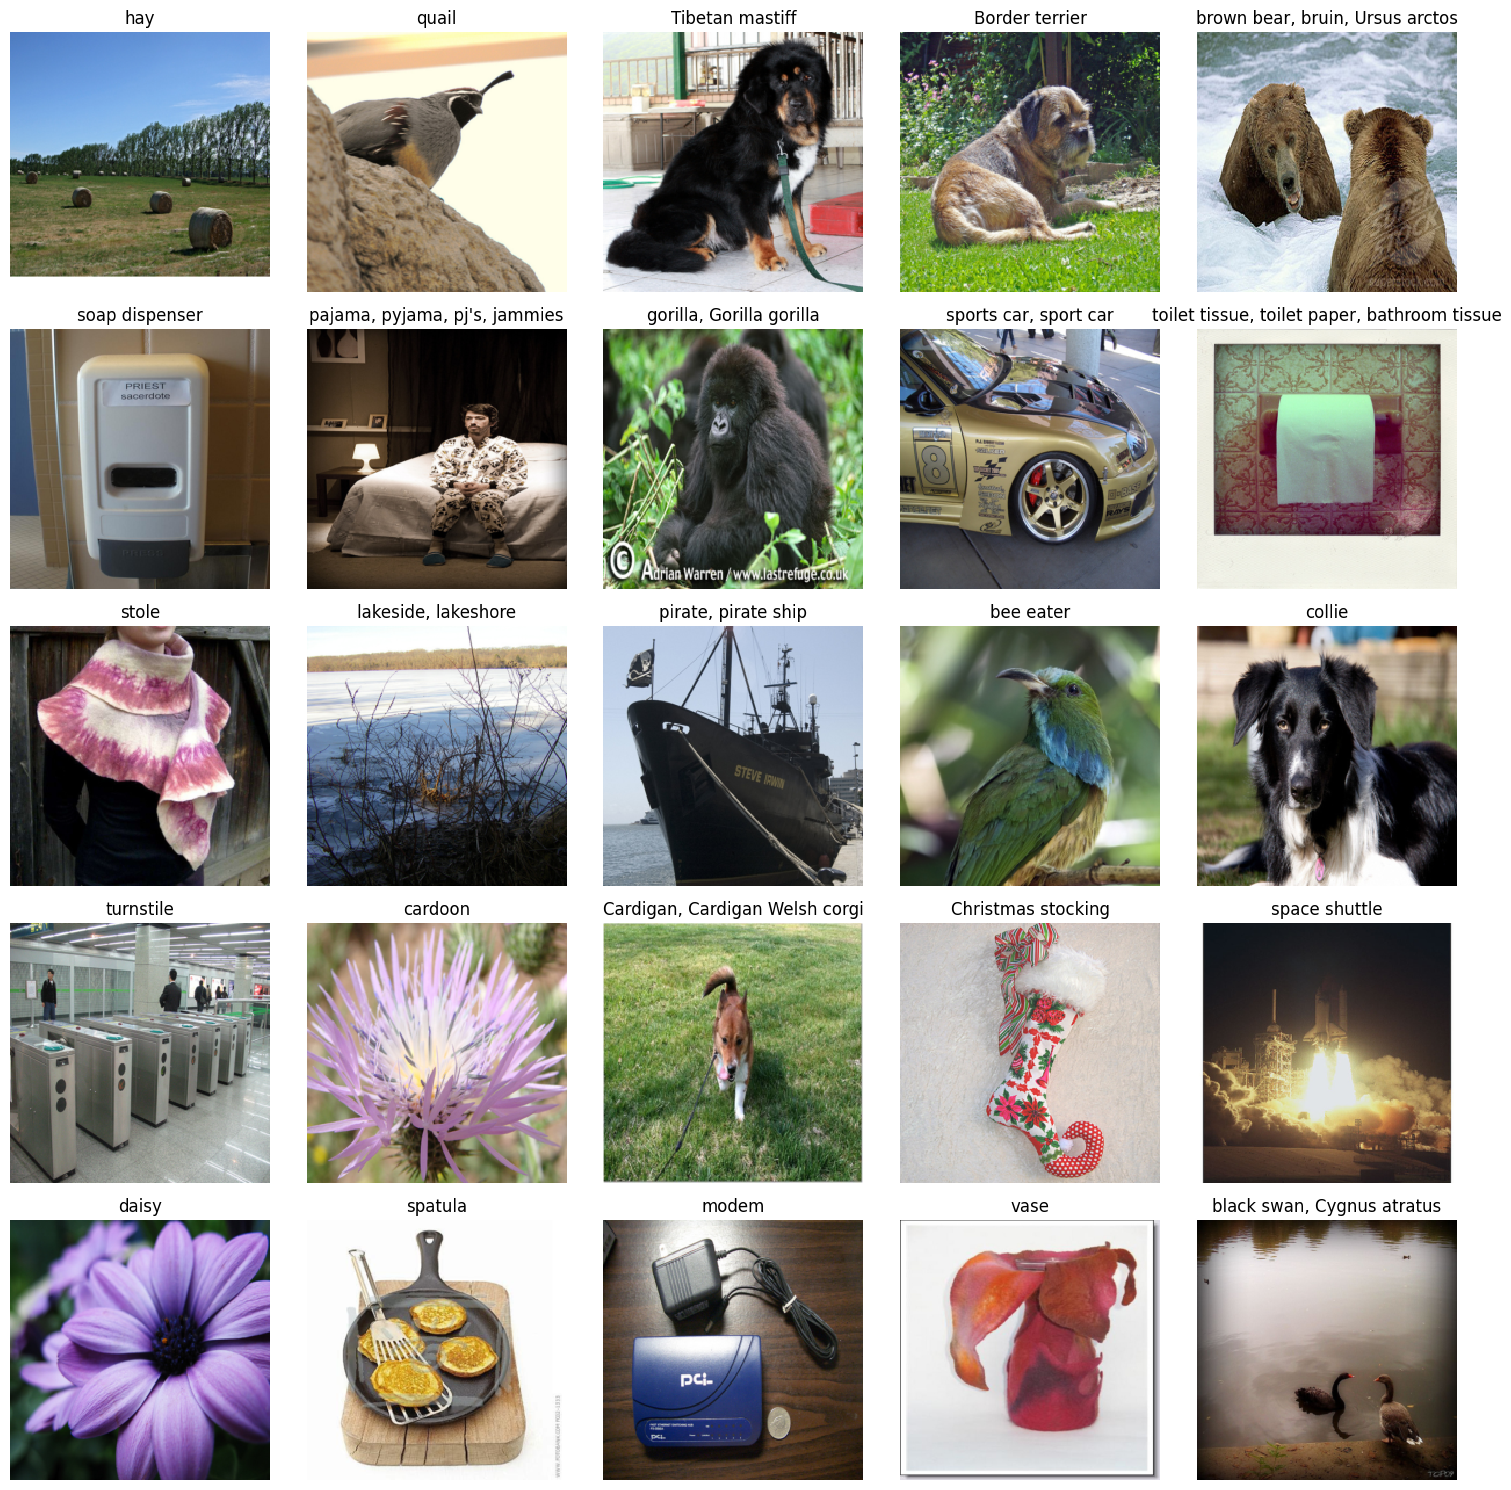

In [6]:
f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

# Class visualization

Write the code which generates an image maximizing the score of a class, subject to a certain number of regularizations. See the TP guide for details.


In [26]:
def create_class_visualization(
    target_y,
    model,
    dtype,
    init_img=None,
    l2_reg=1e-3,
    learning_rate=5,
    num_iterations=200,
    blur_every=10,
    max_jitter=16,
    show_every=25,
    gif=True,
    filename=None
):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    if gif:
        # for GIF creation
        gif_frames = []

    # Randomly initialize the image as a PyTorch Tensor
    if init_img is None:
        img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).detach()
    else:
        img = init_img.clone().mul_(1.0).type(dtype).detach()
    img.requires_grad = True

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img = (jitter(img, ox, oy)).clone().detach()
        img.requires_grad = True

        ########################################################################
        # - TODO: Use the model to compute the gradient of the score for the   #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # - Be very careful about the signs of elements in your code.          #
        # - Advice: compute backward on the raw logits (not the loss), it      #
        # works better                                                         #
        ########################################################################
        # Forward pass
        scores = model(img)  # (1, 1000)
        target_score = scores[:, target_y].squeeze()
        # Add the regularization term (L2 norm is squared).
        target_score -= l2_reg * torch.square(torch.linalg.norm(img))

        # Backward pass
        target_score.backward()

        # Update step: gradient ascent.
        img.data += learning_rate * img.grad.data

        # Re-initialize the gradient of "img" to zero.
        img.grad.data.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        # Undo the random jitter
        img.data.copy_(jitter(img, -ox, -oy))
        img = img.clone()

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)

        # GIF creation
        # Create a buffer, which prevent saving hundreds of images on the disk.
        buf = io.BytesIO()
        # "Show" the image, so we are able to save it.
        plt.imshow(deprocess(img.clone().cpu()))
        class_name = class_names[target_y]
        plt.title("%s\nIteration %d / %d" % (class_name, t + 1, num_iterations))
        plt.gcf().set_size_inches(4, 4)
        plt.axis("off")
        # Save the image in the buffer.
        plt.savefig(buf, format="png", dpi=100, bbox_inches="tight")
        buf.seek(0)
        # Append the buffered image to an array.
        gif_frames.append(imageio.v2.imread(buf))
        # Close the image, so it's not displayed.
        plt.close()
        if (not gif) and show_every:
            # Periodically show the image
            if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
                plt.imshow(deprocess(img.clone().cpu()))
                class_name = class_names[target_y]
                plt.title("%s\nIteration %d / %d" % (class_name, t + 1, num_iterations))
                plt.gcf().set_size_inches(4, 4)
                plt.axis("off")
                plt.show()

    if filename:
        # Create and save the GIF, using the buffers stored in the array.
        imageio.imsave(f"figs_propre/{model._get_name()}/{model._get_name()}_{filename}_last_frame.png", gif_frames[-1])
    if gif:
        imageio.mimsave(f"figs_propre/{model._get_name()}/{model._get_name()}_{filename}.gif", gif_frames, duration=0.1, loop=0)
        return gif_frames
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)
pass

# With SqueezeNet

## Learning rate

## Iterations

Bee eater

In [ ]:
target_y = 92  # bee eater
create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"bird_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"bird_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{model._get_name()}/{model._get_name()}_bird_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

## Regularization

### From noise

bee eater

In [ ]:
# Initialize test
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated",
)

### Starting img

bee eater

In [ ]:
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img",
)

## Starting image

### Same class

See above

### Different class

In [ ]:
img_ind = 0 # Hai
target_y = 113   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=500, filename="snail_animated_init_img_reg++", l2_reg=1e-5, blur_every=2
)

# Same with VGG

## Iterations

Gorilla

In [ ]:
target_y = 366  # Gorilla
create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{vgg16._get_name()}/{vgg16._get_name()}_Gorilla_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

KeyboardInterrupt: 

Bee eater

In [ ]:
target_y = 92  # bee eater
create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"bird_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"bird_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{vgg16._get_name()}/{vgg16._get_name()}_bird_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

## Regularization

### From noise

Gorilla

In [ ]:
# Initialize test
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated",
)

bee eater

In [ ]:
# Initialize test
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated",
)

### Starting img

Gorilla

In [ ]:
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img",
)

bee eater

In [ ]:
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img",
)

## Starting image

### Same class

See above

### Different class

In [ ]:
img_ind = 0 # Hai
target_y = 113   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="snail_animated_init_img_reg++", l2_reg=1e-5, blur_every=2
)